<a href="https://colab.research.google.com/github/ThePickleBaron/ColumbusTrees/blob/main/Capacity2019UpdatedForMinnie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Capacity model for Minnie

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class ProductionSystem:
    """A more elegant approach to production capacity modeling using simulation."""

    def __init__(self, params):
        """Initialize the production system with its parameters."""
        self.mix_tanks = params['MX']
        self.holding_tanks = params['HX']
        self.batch_time = params['BT']
        self.transfer_time = params['TT']
        self.line_time = params['LT']
        self.mix_cleaning_time = params['MCT']
        self.holding_cleaning_time = params['HCT']
        self.lost_capacity = params['LC']

        # Adjust production time by lost capacity factor
        self.effective_line_time = self.line_time * (1 - self.lost_capacity)

        # Initialize states
        self.mix_tank_available = [0] * int(self.mix_tanks)  # Time when each mix tank becomes available
        self.holding_tank_available = [0] * int(self.holding_tanks)  # Time when each holding tank becomes available

        # Track batches
        self.completed_batches = []
        self.current_time = 0

    def reset(self):
        """Reset the system to initial state."""
        self.mix_tank_available = [0] * int(self.mix_tanks)
        self.holding_tank_available = [0] * int(self.holding_tanks)
        self.completed_batches = []
        self.current_time = 0

    def process_batch(self):
        """Process a single batch through the system and return completion time."""
        # Find earliest available mix tank
        mix_tank_idx = np.argmin(self.mix_tank_available)
        mix_start_time = self.mix_tank_available[mix_tank_idx]
        mix_end_time = mix_start_time + self.batch_time

        # After mixing, transfer to holding tank
        transfer_end_time = mix_end_time + self.transfer_time

        # Find earliest available holding tank that will be free by transfer end time
        hold_available_after_transfer = []
        for i, time in enumerate(self.holding_tank_available):
            if time <= transfer_end_time:
                hold_available_after_transfer.append((i, time))

        if not hold_available_after_transfer:
            # No holding tank will be available, find the earliest one
            holding_tank_idx = np.argmin(self.holding_tank_available)
            hold_start_time = self.holding_tank_available[holding_tank_idx]
        else:
            # Choose the earliest available holding tank
            holding_tank_idx, _ = min(hold_available_after_transfer, key=lambda x: x[1])
            hold_start_time = transfer_end_time

        # Production line time
        production_end_time = hold_start_time + self.effective_line_time

        # Update availability times with cleaning
        self.mix_tank_available[mix_tank_idx] = mix_end_time + self.mix_cleaning_time
        self.holding_tank_available[holding_tank_idx] = production_end_time + self.holding_cleaning_time

        # Record batch completion
        batch_info = {
            'mix_tank': mix_tank_idx + 1,
            'holding_tank': holding_tank_idx + 1,
            'mix_start': mix_start_time,
            'mix_end': mix_end_time,
            'transfer_end': transfer_end_time,
            'hold_start': hold_start_time,
            'production_end': production_end_time,
            'total_time': production_end_time - mix_start_time
        }

        self.completed_batches.append(batch_info)
        self.current_time = max(self.current_time, production_end_time)

        return production_end_time

    def simulate(self, time_period):
        """Simulate production for a given time period and return the number of completed batches."""
        self.reset()
        batch_count = 0

        while True:
            completion_time = self.process_batch()
            if completion_time <= time_period:
                batch_count += 1
            else:
                # Remove the last batch if it exceeds the time period
                if self.completed_batches:
                    self.completed_batches.pop()
                break

        return batch_count

    def get_schedule_dataframe(self):
        """Return the schedule as a pandas DataFrame."""
        if not self.completed_batches:
            return pd.DataFrame()

        return pd.DataFrame(self.completed_batches)

    def plot_gantt_chart(self, time_limit=None):
        """Create a Gantt chart of the production schedule."""
        if not self.completed_batches:
            print("No batches completed within the time period")
            # Create an empty plot with a message
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, "No batches completed within the time period",
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes, fontsize=14)
            ax.set_xticks([])
            ax.set_yticks([])
            return fig, ax

        df = self.get_schedule_dataframe()

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(12, 8))

        # Define colors
        colors = plt.cm.tab10.colors

        # Plot mix tank usage
        for i, batch in enumerate(self.completed_batches):
            mix_tank = batch['mix_tank']
            # Mixing phase
            ax.barh(f"Mix Tank {mix_tank}",
                    width=batch['mix_end'] - batch['mix_start'],
                    left=batch['mix_start'],
                    color=colors[0],
                    alpha=0.7,
                    label='Mixing' if i == 0 else "")
            # Cleaning phase
            ax.barh(f"Mix Tank {mix_tank}",
                    width=self.mix_cleaning_time,
                    left=batch['mix_end'],
                    color=colors[1],
                    alpha=0.7,
                    hatch='///',
                    label='Mix Tank Cleaning' if i == 0 else "")

        # Plot holding tank usage
        for i, batch in enumerate(self.completed_batches):
            hold_tank = batch['holding_tank']
            # Production phase
            ax.barh(f"Hold Tank {hold_tank}",
                    width=batch['production_end'] - batch['hold_start'],
                    left=batch['hold_start'],
                    color=colors[2],
                    alpha=0.7,
                    label='Production' if i == 0 else "")
            # Cleaning phase
            ax.barh(f"Hold Tank {hold_tank}",
                    width=self.holding_cleaning_time,
                    left=batch['production_end'],
                    color=colors[3],
                    alpha=0.7,
                    hatch='\\\\\\',
                    label='Hold Tank Cleaning' if i == 0 else "")

        # Set time limit if provided
        if time_limit:
            ax.set_xlim(0, time_limit)

        # Set labels and title
        ax.set_xlabel('Time (hours)')
        ax.set_title('Production Schedule Gantt Chart')

        # Add a legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

        # Adjust layout and grid
        ax.grid(axis='x', alpha=0.3)
        plt.tight_layout()

        return fig, ax

    def analyze_bottleneck(self):
        """Identify the system bottleneck."""
        if not self.completed_batches:
            # Return empty analysis dictionary instead of a string
            return {
                'bottleneck': 'None - No batches completed',
                'bottleneck_utilization': 0.0,
                'avg_mix_utilization': 0.0,
                'avg_hold_utilization': 0.0,
                'process_durations': {
                    'mixing': self.batch_time,
                    'transfer': self.transfer_time,
                    'production': self.effective_line_time,
                    'mix_cleaning': self.mix_cleaning_time,
                    'hold_cleaning': self.holding_cleaning_time
                },
                'theoretical_min_time': self.batch_time + self.transfer_time + self.effective_line_time
            }

        # Calculate utilization rates
        mix_tanks_usage = {i+1: 0 for i in range(int(self.mix_tanks))}
        holding_tanks_usage = {i+1: 0 for i in range(int(self.holding_tanks))}

        for batch in self.completed_batches:
            # Mix tank usage (mixing + cleaning)
            mix_tanks_usage[batch['mix_tank']] += (batch['mix_end'] - batch['mix_start']) + self.mix_cleaning_time

            # Holding tank usage (production + cleaning)
            holding_tanks_usage[batch['holding_tank']] += (batch['production_end'] - batch['hold_start']) + self.holding_cleaning_time

        # Calculate average utilization
        avg_mix_utilization = sum(mix_tanks_usage.values()) / (self.current_time * int(self.mix_tanks))
        avg_hold_utilization = sum(holding_tanks_usage.values()) / (self.current_time * int(self.holding_tanks))

        # Calculate process step durations
        avg_mix_time = self.batch_time
        avg_transfer_time = self.transfer_time
        avg_production_time = self.effective_line_time
        avg_mix_cleaning_time = self.mix_cleaning_time
        avg_hold_cleaning_time = self.holding_cleaning_time

        results = {
            'avg_mix_utilization': avg_mix_utilization * 100,
            'avg_hold_utilization': avg_hold_utilization * 100,
            'process_durations': {
                'mixing': avg_mix_time,
                'transfer': avg_transfer_time,
                'production': avg_production_time,
                'mix_cleaning': avg_mix_cleaning_time,
                'hold_cleaning': avg_hold_cleaning_time
            },
            'theoretical_min_time': avg_mix_time + avg_transfer_time + avg_production_time
        }

        # Determine bottleneck
        if avg_mix_utilization > avg_hold_utilization:
            results['bottleneck'] = 'Mix Tanks'
            results['bottleneck_utilization'] = avg_mix_utilization * 100
        else:
            results['bottleneck'] = 'Holding Tanks'
            results['bottleneck_utilization'] = avg_hold_utilization * 100

        return results


def analyze_capacity(params, time_period=24, plot=False):
    """Analyze production capacity with the given parameters."""
    system = ProductionSystem(params)
    batch_count = system.simulate(time_period)

    print(f"Maximum number of batches that can be produced in {time_period} hours: {batch_count}")

    # Add theoretical cycle time analysis
    theoretical_min_hours = params['BT'] + params['TT'] + params['LT'] * (1 - params['LC'])
    theoretical_max_batches = time_period / theoretical_min_hours

    print(f"Theoretical minimum cycle time: {theoretical_min_hours:.1f} hours")
    print(f"Theoretical maximum batches (single tank, no cleaning): {int(theoretical_max_batches)}")

    bottleneck_analysis = system.analyze_bottleneck()
    print("\nBottleneck Analysis:")
    print(f"Bottleneck: {bottleneck_analysis['bottleneck']} with {bottleneck_analysis['bottleneck_utilization']:.1f}% utilization")
    print(f"Mix Tanks Utilization: {bottleneck_analysis['avg_mix_utilization']:.1f}%")
    print(f"Holding Tanks Utilization: {bottleneck_analysis['avg_hold_utilization']:.1f}%")

    print("\nProcess Step Durations:")
    for step, duration in bottleneck_analysis['process_durations'].items():
        print(f"  {step.capitalize()}: {duration} hours")

    if plot:
        system.plot_gantt_chart(time_period)
        plt.show()

    return {
        'batch_count': batch_count,
        'bottleneck_analysis': bottleneck_analysis,
        'system': system
    }


def run_scenarios(base_params, scenarios, time_period=24):
    """Run multiple scenarios and compare results."""
    results = {}

    # Run base scenario
    print("Base Scenario:")
    base_results = analyze_capacity(base_params, time_period=time_period, plot=False)
    results['base'] = base_results['batch_count']

    # Run additional scenarios
    for name, param_changes in scenarios.items():
        print(f"\n{name} Scenario:")
        # Create a copy of base parameters and update with scenario changes
        scenario_params = base_params.copy()
        for key, value in param_changes.items():
            scenario_params[key] = value

        scenario_results = analyze_capacity(scenario_params, time_period=time_period, plot=False)
        results[name] = scenario_results['batch_count']

    # Compare results
    print(f"\nScenario Comparison ({time_period}-hour capacity):")
    for name, batches in results.items():
        if name == 'base':
            print(f"  Base Scenario: {batches} batches")
        else:
            change = batches - results['base']
            if results['base'] > 0:
                percent = (change / results['base'] * 100)
                print(f"  {name} Scenario: {batches} batches ({'+' if change >= 0 else ''}{change} batches, {'+' if change >= 0 else ''}{percent:.1f}%)")
            else:
                if batches > 0:
                    print(f"  {name} Scenario: {batches} batches (∞% improvement from zero)")
                else:
                    print(f"  {name} Scenario: {batches} batches (no change from zero)")

    return results




### **HIT PLAY ON THE CODE ABOVE, THEN FILL IN THE PARAMETERS BELOW AND RUN THIS CODE.  CAPACITY WILL BE DISPLAYED BELOW.**


===== 24-HOUR ANALYSIS =====
Maximum number of batches that can be produced in 120 hours: 32
Theoretical minimum cycle time: 36.3 hours
Theoretical maximum batches (single tank, no cleaning): 3

Bottleneck Analysis:
Bottleneck: Mix Tanks with 71.7% utilization
Mix Tanks Utilization: 71.7%
Holding Tanks Utilization: 34.9%

Process Step Durations:
  Mixing: 20.0 hours
  Transfer: 1.0 hours
  Production: 15.299999999999999 hours
  Mix_cleaning: 3.0 hours
  Hold_cleaning: 1.5 hours


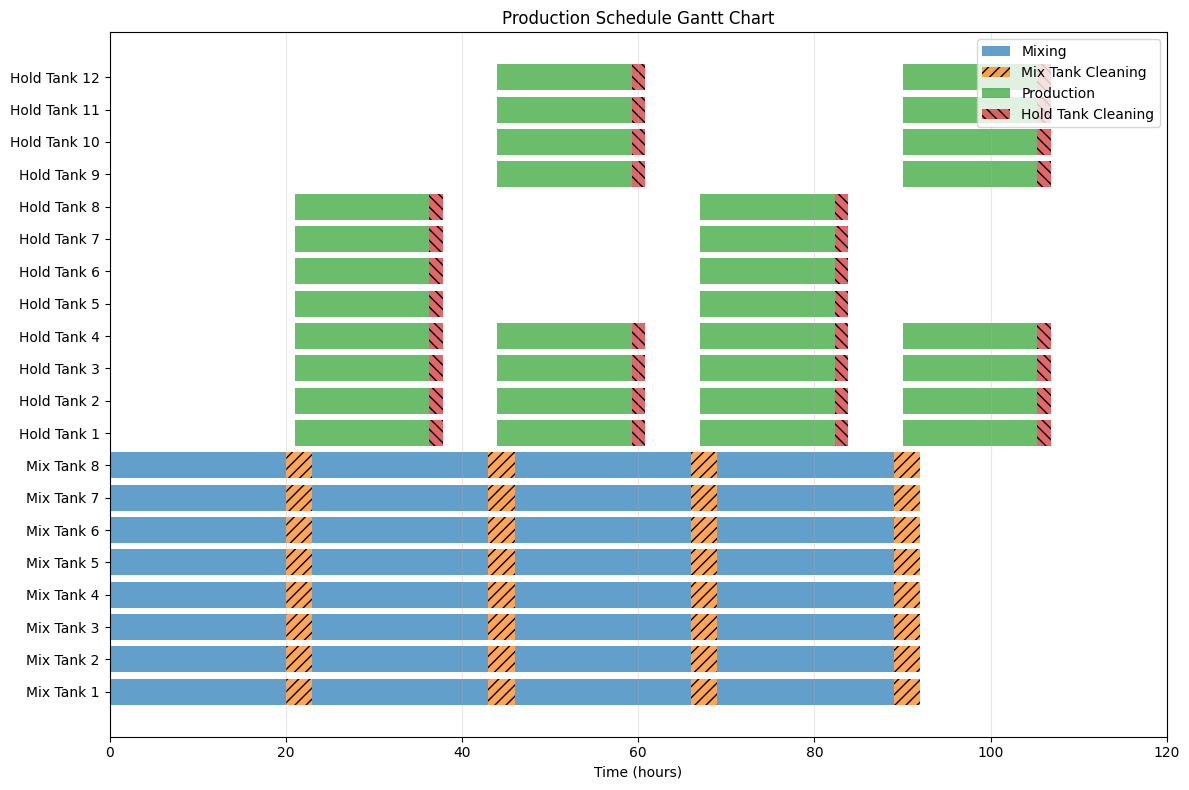


===== 48-HOUR ANALYSIS =====
Maximum number of batches that can be produced in 504 hours: 168
Theoretical minimum cycle time: 36.3 hours
Theoretical maximum batches (single tank, no cleaning): 13

Bottleneck Analysis:
Bottleneck: Mix Tanks with 93.0% utilization
Mix Tanks Utilization: 93.0%
Holding Tanks Utilization: 45.3%

Process Step Durations:
  Mixing: 20.0 hours
  Transfer: 1.0 hours
  Production: 15.299999999999999 hours
  Mix_cleaning: 3.0 hours
  Hold_cleaning: 1.5 hours


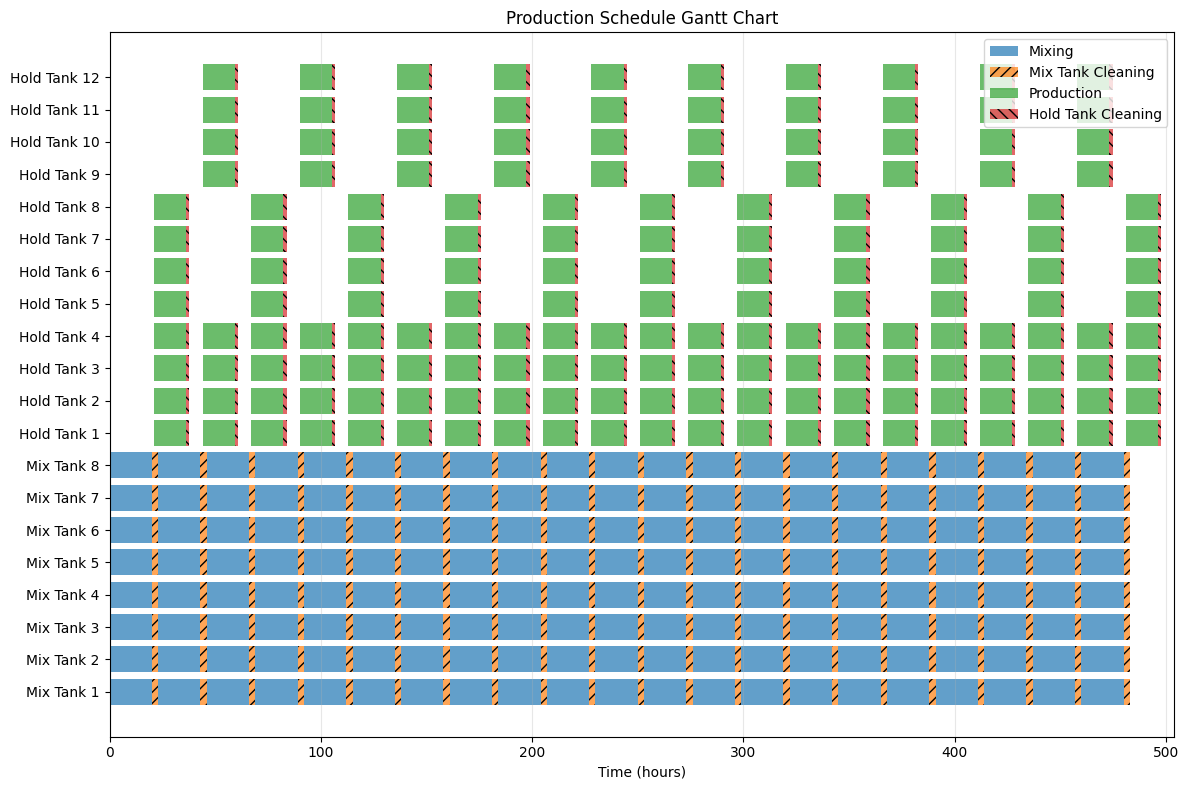


===== SCENARIO ANALYSIS (48 HOURS) =====
Base Scenario:
Maximum number of batches that can be produced in 48 hours: 8
Theoretical minimum cycle time: 36.3 hours
Theoretical maximum batches (single tank, no cleaning): 1

Bottleneck Analysis:
Bottleneck: Mix Tanks with 38.8% utilization
Mix Tanks Utilization: 38.8%
Holding Tanks Utilization: 18.9%

Process Step Durations:
  Mixing: 20.0 hours
  Transfer: 1.0 hours
  Production: 15.299999999999999 hours
  Mix_cleaning: 3.0 hours
  Hold_cleaning: 1.5 hours

Reduce Mix Time by 25% Scenario:
Maximum number of batches that can be produced in 48 hours: 8
Theoretical minimum cycle time: 31.3 hours
Theoretical maximum batches (single tank, no cleaning): 1

Bottleneck Analysis:
Bottleneck: Mix Tanks with 36.5% utilization
Mix Tanks Utilization: 36.5%
Holding Tanks Utilization: 22.7%

Process Step Durations:
  Mixing: 15.0 hours
  Transfer: 1.0 hours
  Production: 15.299999999999999 hours
  Mix_cleaning: 3.0 hours
  Hold_cleaning: 1.5 hours

Doub

In [ ]:
# Example usage
if __name__ == "__main__":
    # Parameters
    params = {
        'MX': 8.0,        # Number of mix tanks
        'HX': 12.0,       # Number of holding tanks
        'BT': 20.0,       # Time to mix a batch (hours)
        'TT': 1.0,        # Transfer time (hours)
        'LT': 18.0,       # Production line time (hours)
        'MCT': 3.0,       # Mix tank cleaning time (hours)
        'HCT': 1.5,       # Holding tank cleaning time (hours)
        'LC': 0.15,       # Lost capacity factor (15% of tank capacity not utilized)
    }

    # First, let's see if any batches can complete in 24 hours
    print("\n===== 24-HOUR ANALYSIS =====")
    day_analysis = analyze_capacity(params, time_period=120, plot=True)

    # For a more meaningful analysis, let's also look at a 48-hour period
    print("\n===== 48-HOUR ANALYSIS =====")
    two_day_analysis = analyze_capacity(params, time_period=504, plot=True)

    # Run what-if scenarios on the 48-hour window for more meaningful results
    print("\n===== SCENARIO ANALYSIS (48 HOURS) =====")
    scenarios = {
        'Reduce Mix Time by 25%': {'BT': params['BT'] * 0.75},
        'Double Mix Tanks': {'MX': params['MX'] * 2},
        'Reduce Cleaning Time': {'MCT': params['MCT'] * 0.5, 'HCT': params['HCT'] * 0.5},
        'Optimized Process': {'BT': params['BT'] * 0.75, 'MCT': params['MCT'] * 0.5, 'HCT': params['HCT'] * 0.5}
    }

    scenario_results = run_scenarios(params, scenarios, time_period=48)

    # Weekly capacity
    print("\n===== WEEKLY ANALYSIS (120 HOURS) =====")
    weekly_capacity = analyze_capacity(params, time_period=5*24, plot=False)